In [1]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append("../")
import elanwriter
from process_AU import *

### Load a csv file with openface results

In [3]:
input_file = "video3"
datafile = pd.read_csv(input_file+".csv",skipinitialspace=True )

### Generate emotions from the Action Units (AU) generated with openface

In [4]:
datafile = generateEmotionsFromAU(datafile)
datafile.head()

,frame,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,...,sad,fear,anger,disgust,happy_c,surprise_c,sad_c,fear_c,anger_c,disgust_c
0,1,0.000000,0.921208,1,0.077684,0.000579,-0.996978,-0.070728,0.022693,-0.997237,...,0.476665,0.268259,0.317960,0.302084,0.0,0.25,0.333333,0.142857,0.5,0.5
1,2,0.033556,0.926320,1,0.111916,0.032193,-0.993196,-0.061005,0.043572,-0.997186,...,0.410183,0.176161,0.251594,0.312065,0.0,0.25,0.333333,0.142857,0.5,0.5
2,3,0.067112,0.928005,1,0.118085,0.035448,-0.992371,-0.051068,0.036808,-0.998017,...,0.416204,0.130386,0.221986,0.346043,0.0,0.25,0.333333,0.142857,0.5,0.5
3,4,0.100667,0.925478,1,0.123202,0.023357,-0.992107,-0.071824,0.051248,-0.996100,...,0.419726,0.142757,0.243635,0.298745,0.0,0.25,0.333333,0.142857,0.5,0.5
4,5,0.134223,0.923283,1,0.139863,0.043131,-0.989231,-0.077694,0.047579,-0.995841,...,0.422113,0.118037,0.206564,0.317148,0.0,0.25,0.333333,0.142857,0.5,0.5


### Getting time interfals

We analyse the openface results and get some time interfals for face detection and confidences and for emotions like happy/surpriced

In [5]:
times_succes = getSuccessTimes(datafile)
times_confident = getUnConfidenceTimes(datafile, confidence_threshold = 0.8)
times_fail = getFailTimes(datafile)

times_happy = getActivationTimes(datafile, "happy", 2, method="mean")
times_sur = getActivationTimes(datafile, "surprise", 2)

# This is a second list of timestamps indicating when a happy face is detected. We use some smoothing and thresholding. 
# So we only want timestamps where the emotion holds for longer than a certain time (time_threshold). Also when a happy
# face is detected only after time_gap_smoothing second of no happy face detection will the timestamp end (or in other 
# words, different moments of happyness will be merged to one if they are separated by only time_gap_smoothing seconds)
times_happy_2 = getActivationTimes(datafile, "happy", 2, method="mean", time_gap_smoothing=0.3, time_threshold=0.1)
times_happy_3 = getActivationTimes(datafile, "happy", 2, method="mean", time_gap_smoothing=0.3, time_threshold=0.1,
                                  confidence_cut=0.8)

### We plot the face and landmark confidence for the video

The locations where the confidence is larger than 80% is marked with red bars

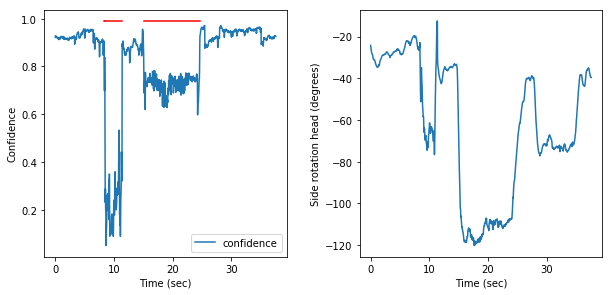

In [30]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(datafile['timestamp'], datafile["confidence"], label="confidence")
y=0.99
for t in times_confident:
    plt.plot((t[0],t[1]), (y,y), color="red")
plt.xlabel("Time (sec)")
plt.ylabel("Confidence")
plt.legend()

plt.subplot(2,2,2)
plt.plot(datafile['timestamp'], datafile['pose_Tx'])
plt.xlabel("Time (sec)")
plt.ylabel("Side rotation head (degrees)")

fig.subplots_adjust(wspace=0.3)#, hspace=0)
plt.show()

### Now we plot happiness as function of time together with the detected timestamp periods

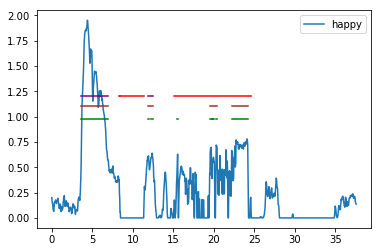

In [14]:
plt.plot(datafile['timestamp'], datafile["happy"], label="happy")

y=0.98
for t in times_happy:
    plt.plot((t[0],t[1]), (y,y), color="green")
y=1.1
for t in times_happy_2:
    plt.plot((t[0],t[1]), (y,y), color="brown")

y=1.2
for t in times_happy_3:
    plt.plot((t[0],t[1]), (y,y), color="purple")

y=1.2
for t in times_confident:
    plt.plot((t[0],t[1]), (y,y), color="red")
plt.legend()
plt.show()


### We write our happiness and surprise timestamps away in an Elan format

In [15]:
ed = elanwriter.ElanDoc(input_file+".mp4")
for i in range(len(times_confident)):
    ed.add_annotation((1000*times_confident[i][0], 1000*times_confident[i][1]), "<0.8", "Confidence")
for i in range(len(times_happy_3)):
    #print(str(round(times[i]*1000, 0)))
    ed.add_annotation((1000*times_happy_3[i][0],1000*times_happy_3[i][1]), "happy", "happy_tier")
# for i in range(len(times_sur)):
#     #print(str(round(times[i]*1000, 0)))
#     ed.add_annotation((1000*times_sur[i][0],1000*times_sur[i][1]), "surprise", "surprise_tier")
ed.write(input_file+".eaf")

### Some other code and stuff

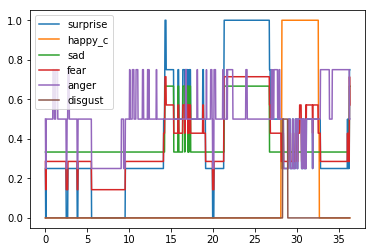

In [7]:
plt.plot(datafile['timestamp'], datafile["surprise_c"], label="surprise")
plt.plot(datafile['timestamp'], datafile["happy_c"], label="happy_c")
plt.plot(datafile['timestamp'], datafile["sad_c"], label="sad")
plt.plot(datafile['timestamp'], datafile["fear_c"], label="fear")
plt.plot(datafile['timestamp'], datafile["anger_c"], label="anger")
plt.plot(datafile['timestamp'], datafile["disgust_c"], label="disgust")
plt.legend()
#plt.xlim(10,100)
plt.show()

In [32]:
datafile.columns[0:30]

Index(['frame', 'timestamp', 'confidence', 'success', 'gaze_0_x', 'gaze_0_y',
       'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 'pose_Tx', 'pose_Ty',
       'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'x_0', 'x_1', 'x_2', 'x_3',
       'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12',
       'x_13'],
      dtype='object')

In [8]:
datafile[datafile["surprise_c"]==1]

,frame,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,...,sad,fear,anger,disgust,happy_c,surprise_c,sad_c,fear_c,anger_c,disgust_c
425,426,14.2742,0.960073,1,0.119731,0.261110,-0.957855,0.032599,0.211003,-0.976942,...,0.467059,0.520559,0.657174,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0
426,427,14.3078,0.961377,1,0.105828,0.271191,-0.956690,0.025248,0.214930,-0.976303,...,0.534959,0.572033,0.660950,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0
427,428,14.3414,0.959195,1,0.119622,0.265340,-0.956706,0.028319,0.209117,-0.977480,...,0.590765,0.592570,0.687688,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0
428,429,14.3750,0.960898,1,0.103881,0.245622,-0.963784,0.035209,0.206365,-0.977841,...,0.589172,0.585459,0.635774,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0
635,636,21.3274,0.959437,1,0.171771,0.186894,-0.967246,0.027134,0.137641,-0.990110,...,0.813571,0.525893,0.579627,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0
636,637,21.3610,0.961829,1,0.177211,0.181197,-0.967349,0.039375,0.124091,-0.991489,...,0.786566,0.564785,0.579048,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0
637,638,21.3945,0.962838,1,0.161245,0.147872,-0.975773,0.027526,0.130659,-0.991045,...,0.766075,0.619400,0.590807,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0
638,639,21.4281,0.958719,1,0.115510,0.153402,-0.981390,0.028226,0.135534,-0.990371,...,0.830752,0.645846,0.593497,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0
639,640,21.4617,0.957911,1,0.160632,0.202072,-0.966108,0.018953,0.135837,-0.990550,...,0.859586,0.636871,0.537923,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0
640,641,21.4953,0.955019,1,0.151899,0.200432,-0.967860,0.028322,0.132533,-0.990774,...,0.912539,0.667384,0.494427,0.0,0.0,1.0,0.666667,0.714286,0.50,0.0


In [9]:
action_units = datafile[['timestamp', 'confidence', 'success', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r',
       'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r',
       'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r',
       'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c',
       'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c',
       'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c']]

In [10]:
action_units.head()

,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,0.000000,0.966620,1,0.0,0.0,2.83808,0.0,0.459499,0.434217,0.211554,...,0,0,0,0,0,0,0,0,1,0
1,0.033586,0.955470,1,0.0,0.0,2.22782,0.0,0.595567,0.517218,0.181446,...,0,0,0,0,0,0,0,0,1,1
2,0.067173,0.954617,1,0.0,0.0,2.06437,0.0,0.620734,0.444341,0.244458,...,0,0,0,0,0,0,0,0,1,1
3,0.100759,0.962668,1,0.0,0.0,2.23947,0.0,0.594918,0.286306,0.284593,...,0,0,0,0,0,0,0,0,1,1
4,0.134346,0.967500,1,0.0,0.0,2.48060,0.0,0.548726,0.276117,0.295876,...,0,0,0,0,0,0,0,0,1,1
